<a href="https://colab.research.google.com/github/hiimjupter/COS40007/blob/main/Portfolio5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 43.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import shutil
import yaml
import cv2

import torch
from torchvision.ops import box_iou
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
HOME = '/content/drive/MyDrive/COS40007/Portfolio5'
DATASET = f'{HOME}/Dataset'

TRAIN_BB = f'{DATASET}/bounding_boxes/train_labels.csv'
TRAIN_IMAGES = f'{DATASET}/images/train'
TRAIN_LABELS = f'{DATASET}/labels/train'

TEST_BB = f'{DATASET}/bounding_boxes/test_labels.csv'
TEST_IMAGES = f'{DATASET}/images/test'
TEST_LABELS = f'{DATASET}/labels/test'

SELECTED = f'{HOME}/Selected'
SELECTED_IMAGES = f'{SELECTED}/images'
SELECTED_TRAIN_IMAGES = f'{SELECTED_IMAGES}/train'
SELECTED_TEST_IMAGES = f'{SELECTED_IMAGES}/test'
SELECTED_LABELS = f'{SELECTED}/labels'
SELECTED_TRAIN_LABELS = f'{SELECTED_LABELS}/train'
SELECTED_TEST_LABELS = f'{SELECTED_LABELS}/test'

OUTPUT = f'{HOME}/evaluation_images'

YAML_PATH = f'{DATASET}/graffiti.yaml'

In [ ]:
# Allow access using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def convert_annotations(csv_file, images_dir, output_dir, class_mapping):
    """
    Converts annotations from a CSV file to YOLO format.

    Args:
        csv_file (str): Path to the CSV file containing annotations.
        images_dir (str): Path to the directory containing images.
        output_dir (str): Path to the directory where YOLO annotations will be saved.
        class_mapping (dict): A dictionary mapping class names to class IDs.
    """
    df = pd.read_csv(csv_file)
    # Use progress_apply for progress bar directly on DataFrame
    tqdm.pandas(desc=f'Converting annotations for {csv_file}')
    df.groupby('filename').progress_apply(lambda group: _process_group(group, images_dir, output_dir, class_mapping))


def _process_group(group, images_dir, output_dir, class_mapping):
    """Processes a single group (corresponding to one image)."""
    filename = group.name  # Get filename from group name
    image_path = os.path.join(images_dir, filename)
    if not os.path.exists(image_path):
        return  # Skip if image does not exist

    img_width = group.iloc[0]['width']
    img_height = group.iloc[0]['height']

    annotations = group.apply(lambda row: _format_annotation(row, img_width, img_height, class_mapping), axis=1).tolist()

    # Write annotations to file
    txt_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(output_dir, txt_filename), 'w') as f:
        f.writelines(ann + '\n' for ann in annotations)


def _format_annotation(row, img_width, img_height, class_mapping):
    """Formats a single annotation row into YOLO format."""
    class_id = class_mapping[row['class']]
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    # Convert to YOLO format
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    bbox_width = (xmax - xmin) / img_width
    bbox_height = (ymax - ymin) / img_height

    return f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}"

In [ ]:
# Define class mapping
class_mapping = {'Graffiti': 0}

# Convert training annotations
convert_annotations(TRAIN_BB, TRAIN_IMAGES, TRAIN_LABELS, class_mapping)

# Convert test annotations
convert_annotations(TEST_BB, TEST_IMAGES, TEST_LABELS, class_mapping)

Converting annotations for /content/drive/MyDrive/COS40007/Portfolio5/Dataset/bounding_boxes/train_labels.csv: 100%|██████████| 813/813 [09:38<00:00,  1.41it/s]
Converting annotations for /content/drive/MyDrive/COS40007/Portfolio5/Dataset/bounding_boxes/test_labels.csv: 100%|██████████| 209/209 [02:24<00:00,  1.45it/s]


In [ ]:
def count_files_in_dir(dir_path):
  """Counts the number of files in a directory."""
  if not os.path.exists(dir_path):
    return 0
  return len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

# Count files in each directory
test_images_count = count_files_in_dir(TEST_IMAGES)
test_labels_count = count_files_in_dir(TEST_LABELS)
train_images_count = count_files_in_dir(TRAIN_IMAGES)
train_labels_count = count_files_in_dir(TRAIN_LABELS)

print(f"Number of files in TRAIN_IMAGES: {train_images_count}")
print(f"Number of files in TRAIN_LABELS: {train_labels_count}")
print(f"Number of files in TEST_IMAGES: {test_images_count}")
print(f"Number of files in TEST_LABELS: {test_labels_count}")

Number of files in TRAIN_IMAGES: 813
Number of files in TRAIN_LABELS: 813
Number of files in TEST_IMAGES: 209
Number of files in TEST_LABELS: 209


In [ ]:
def select_images(source_dir, dest_dir, random_seed, used_images=set()):
    """Selects random images and copies them to the destination directory."""

    images = [f for f in os.listdir(source_dir) if (f.endswith('.jpg') or f.endswith('.JPG')) and f not in used_images]
    selected_images = random.sample(images, min(random_seed, len(images)))
    used_images.update(selected_images)

    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Clear existing files in destination directory
    for file in os.listdir(dest_dir):
        file_path = os.path.join(dest_dir, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

    for img in selected_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))
    return used_images

def copy_annotation(image_dir, label_source_dir, label_dest_dir):
    """Copies annotation files corresponding to images in the image directory."""
    if not os.path.exists(label_dest_dir):
        os.makedirs(label_dest_dir)

    # Clear existing files in destination directory
    for file in os.listdir(label_dest_dir):
        file_path = os.path.join(label_dest_dir, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

    for img_file in os.listdir(image_dir):
        if img_file.endswith('.jpg') or img_file.endswith('.JPG'):
            base_name = os.path.splitext(img_file)[0]
            label_file = base_name + '.txt'
            src_label_path = os.path.join(label_source_dir, label_file)
            dst_label_path = os.path.join(label_dest_dir, label_file)
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dst_label_path)

In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Initialize used images sets
used_train_images = set()
used_test_images = set()

# Select 400 random training images
used_train_images = select_images(TRAIN_IMAGES, SELECTED_TRAIN_IMAGES, 400, used_train_images)

# Copy corresponding training annotation files
copy_annotation(SELECTED_TRAIN_IMAGES, TRAIN_LABELS, SELECTED_TRAIN_LABELS)

# Select 40 random test images
used_test_images = select_images(TEST_IMAGES, SELECTED_TEST_IMAGES, 40, used_test_images)

# Copy corresponding test annotation files
copy_annotation(SELECTED_TEST_IMAGES, TEST_LABELS, SELECTED_TEST_LABELS)

In [ ]:
# Count files in each directory
sel_test_images_count = count_files_in_dir(SELECTED_TEST_IMAGES)
sel_test_labels_count = count_files_in_dir(SELECTED_TEST_LABELS)
sel_train_images_count = count_files_in_dir(SELECTED_TRAIN_IMAGES)
sel_train_labels_count = count_files_in_dir(SELECTED_TRAIN_LABELS)

print(f"Number of files in TRAIN_IMAGES: {sel_train_images_count}")
print(f"Number of files in TRAIN_LABELS: {sel_train_labels_count}")
print(f"Number of files in TEST_IMAGES: {sel_test_images_count}")
print(f"Number of files in TEST_LABELS: {sel_test_labels_count}")

Number of files in TRAIN_IMAGES: 400
Number of files in TRAIN_LABELS: 400
Number of files in TEST_IMAGES: 40
Number of files in TEST_LABELS: 40


In [ ]:
def create_yaml_file(yaml_file_path, train_images_dir, val_images_dir, num_classes, class_names):
    """Creates a YAML file for YOLO object detection."""

    data_dict = {
        'train': train_images_dir,
        'val': val_images_dir,
        'nc': num_classes,
        'names': class_names
    }

    with open(yaml_file_path, 'w') as file:
        yaml.dump(data_dict, file, indent=2)

    print(f"YAML file created at: {yaml_file_path}")

In [ ]:
# Create YAML file
train_images_path = os.path.abspath(SELECTED_TRAIN_IMAGES)
val_images_path = os.path.abspath(SELECTED_TEST_IMAGES)

create_yaml_file(YAML_PATH, train_images_path, val_images_path, num_classes=1, class_names=['Graffiti'])

YAML file created at: /content/drive/MyDrive/COS40007/Portfolio5/Dataset/graffiti.yaml


In [ ]:
# Load the YOLOv11 Model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data=YAML_PATH,  # path to dataset YAML
    epochs=20,  # number of training epochs
    imgsz=640,  # training image size,
    batch=16,
    name='graffiti_detection',
    device=device
)

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/COS40007/Portfolio5/Dataset/graffiti.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=graffiti_detection3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs/detect/graffiti_detection3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/graffiti_detection3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.66G      1.464      3.005      1.396         56        640: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         40         84      0.723      0.249      0.357      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.49G      1.487      2.286      1.367         55        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


                   all         40         84          1     0.0313       0.22       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.44G      1.599      2.296      1.426         89        640: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         40         84      0.491      0.226      0.248      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.45G      1.636      2.247      1.452         59        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         40         84      0.365      0.393      0.314      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.49G      1.658      2.133      1.456         54        640: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         40         84       0.19      0.179     0.0912     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.44G      1.608      2.019      1.456         57        640: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         40         84      0.433        0.5      0.406      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.44G      1.563      1.947      1.413         55        640: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         40         84      0.582      0.564      0.543       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.49G      1.549      1.866      1.392         51        640: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         40         84      0.593      0.399      0.421      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.55G      1.494      1.778      1.385        121        640: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         40         84      0.688      0.447      0.527      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.49G      1.413      1.706       1.34         58        640: 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


                   all         40         84      0.619      0.417      0.481      0.307
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.49G      1.434      1.861      1.362         39        640: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         40         84      0.592        0.5      0.543      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.43G      1.355       1.71      1.317         39        640: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         40         84       0.66      0.643      0.621      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.45G      1.364      1.676      1.306         45        640: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         40         84      0.688      0.571      0.654      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.41G      1.298      1.584       1.27         47        640: 100%|██████████| 25/25 [00:11<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         40         84      0.734      0.592      0.629       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.41G      1.271       1.53      1.259         38        640: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         40         84      0.799      0.615      0.702      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.43G      1.206      1.453      1.211         29        640: 100%|██████████| 25/25 [00:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         40         84      0.722      0.619      0.628      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.43G      1.204       1.39      1.201         31        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         40         84      0.725      0.619      0.661      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.43G       1.18      1.362      1.187         46        640: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


                   all         40         84      0.656      0.702      0.702      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.41G      1.128      1.274      1.155         22        640: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         40         84      0.699      0.667      0.701      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.43G      1.113      1.261      1.134         37        640: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         40         84      0.717      0.655      0.686      0.473



20 epochs completed in 0.084 hours.
Optimizer stripped from runs/detect/graffiti_detection3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/graffiti_detection3/weights/best.pt, 5.5MB

Validating runs/detect/graffiti_detection3/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


                   all         40         84       0.71      0.667      0.701      0.482
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/graffiti_detection3



image 1/1 /content/drive/MyDrive/COS40007/Portfolio5/Dataset/graffiti-toronto.webp: 384x640 3 Graffitis, 16.7ms
Speed: 3.4ms preprocess, 16.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


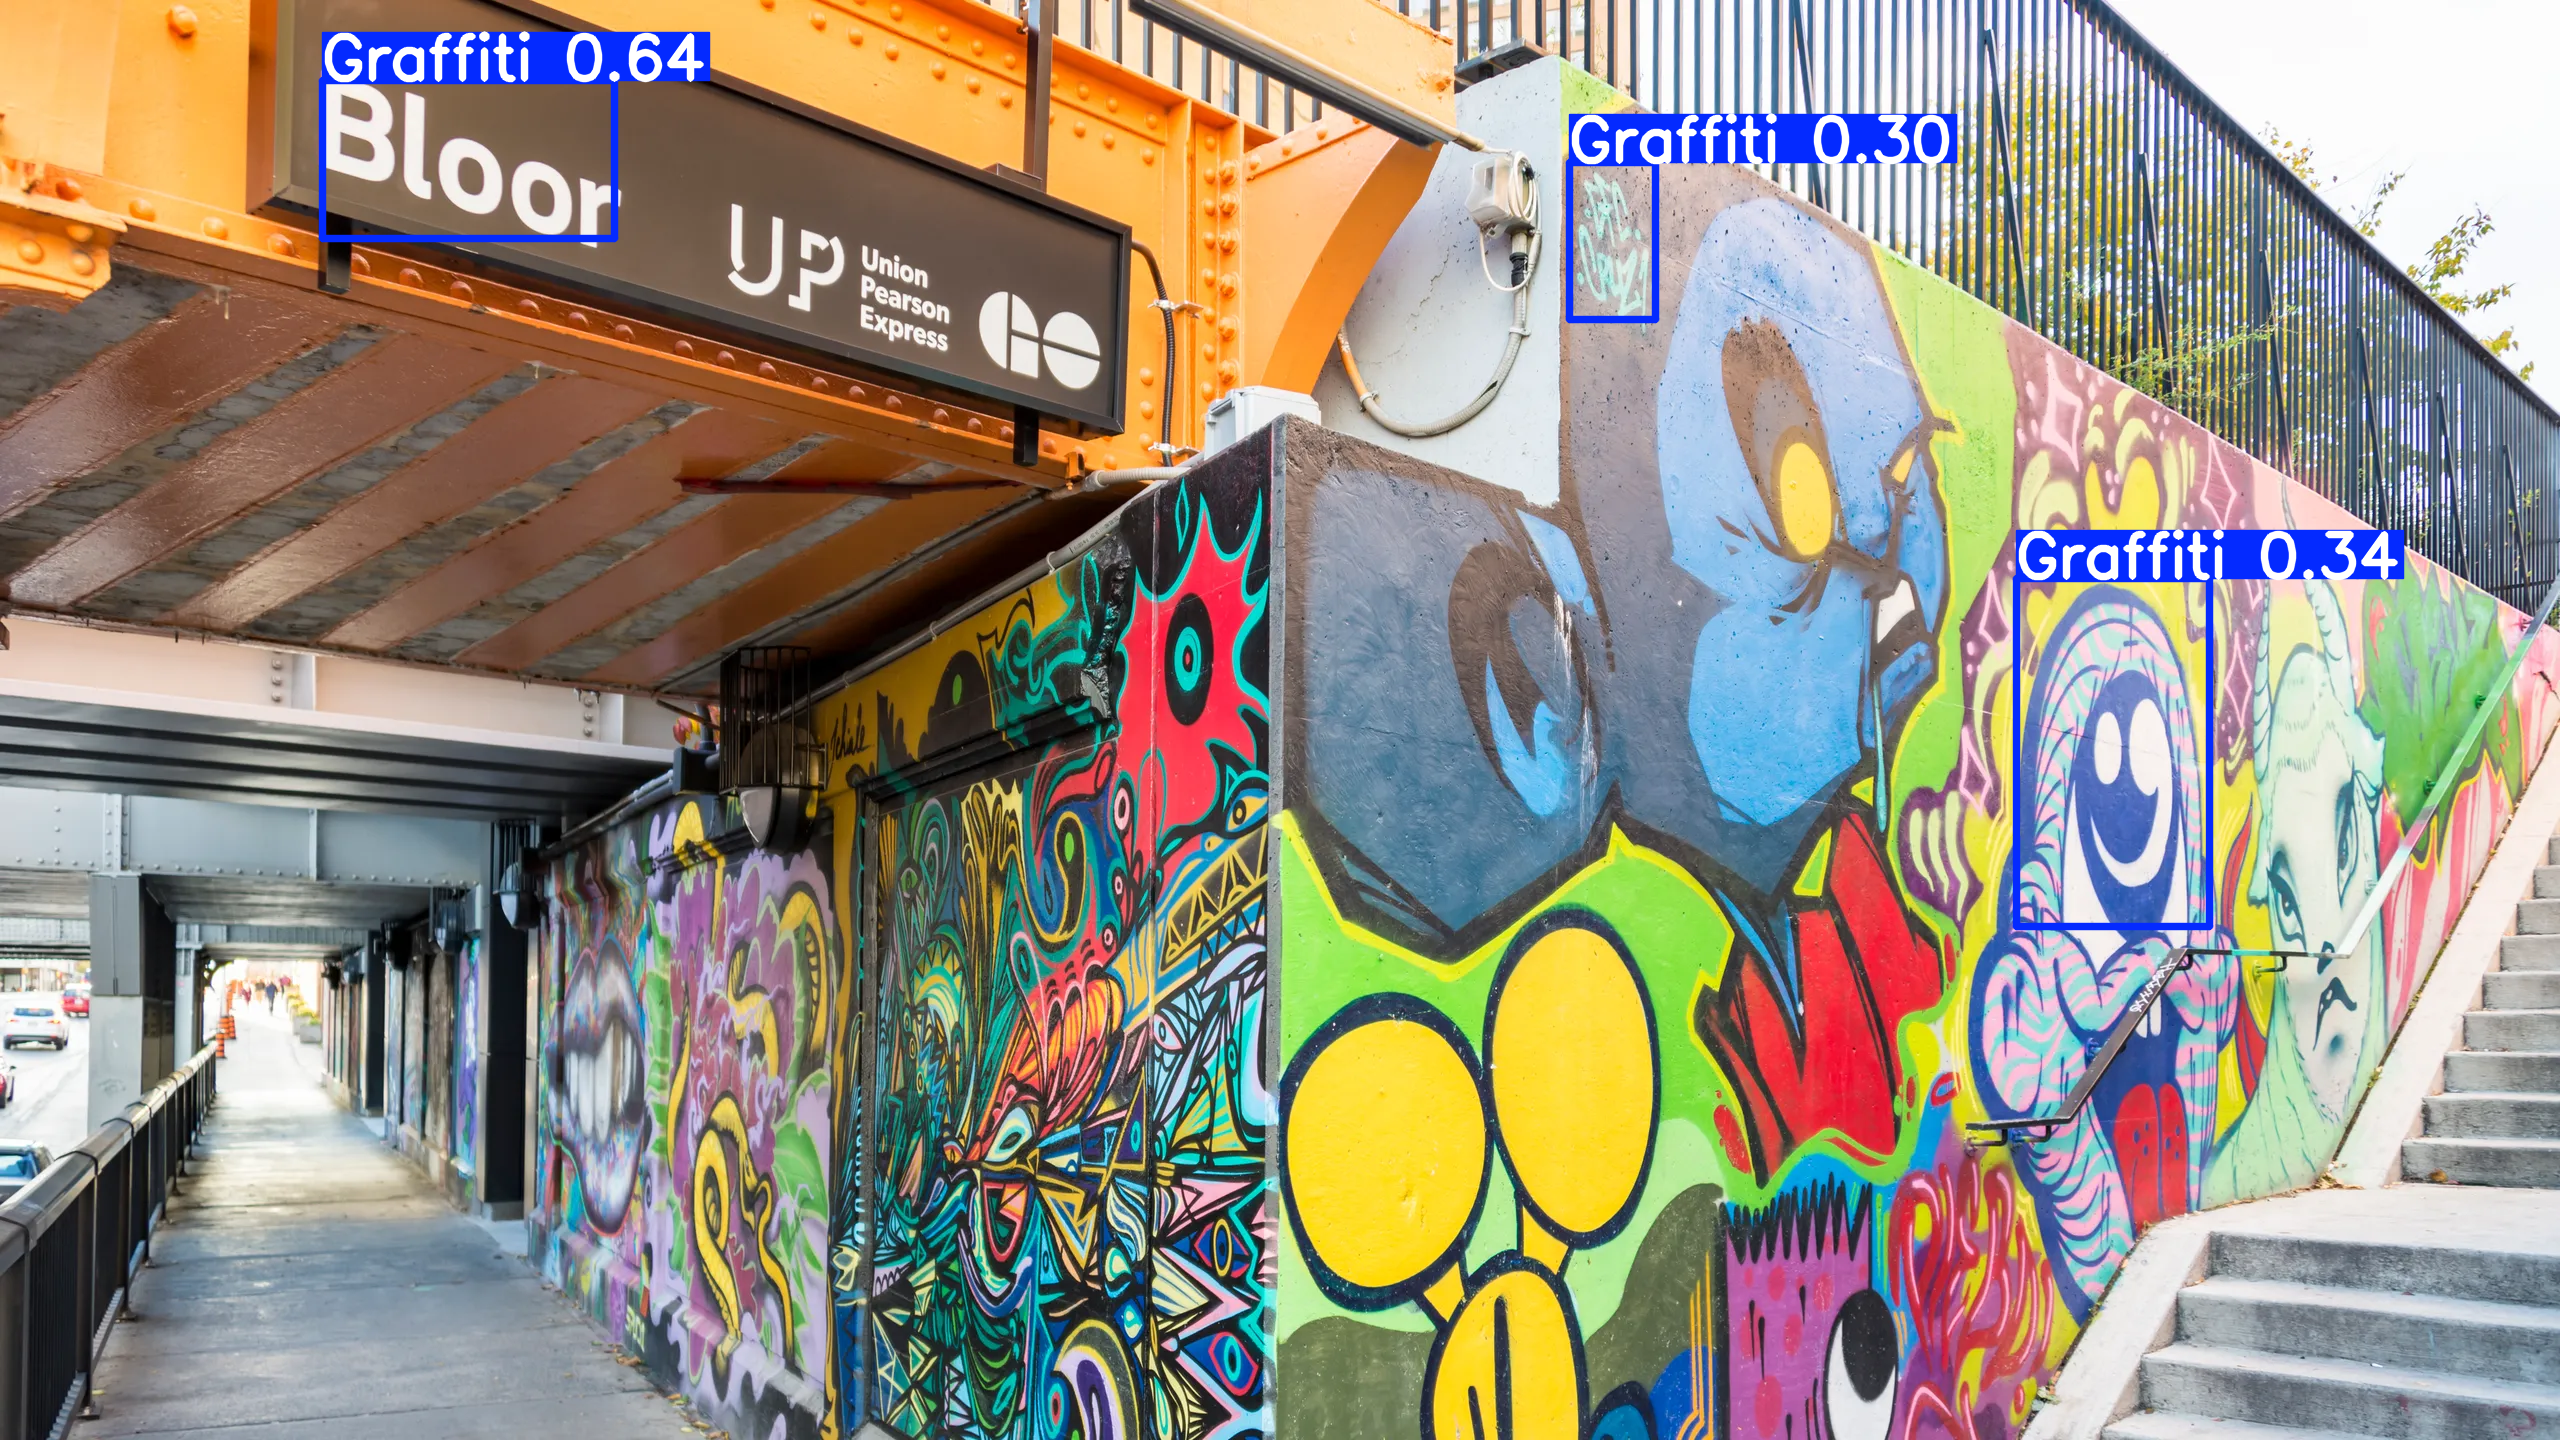

In [ ]:
# Test object detection using YOLOv11
image_path = f'{DATASET}/graffiti-toronto.webp'

# Perform object detection on an image
results = model(image_path)
results[0].show()

In [ ]:
def compute_iou(pred_box, true_box):
    """
    Computes the Intersection over Union (IoU) between two bounding boxes.

    Args:
        pred_box (list): Predicted bounding box coordinates [x1, y1, x2, y2].
        true_box (list): True bounding box coordinates [x1, y1, x2, y2].

    Returns:
        float: IoU score between 0 and 1.
    """
    # Convert boxes to PyTorch tensors
    pred_box = torch.tensor(pred_box)
    true_box = torch.tensor(true_box)

    # Calculate the (x1, y1) coordinates of the intersection rectangle
    inter_x1 = torch.max(pred_box[0], true_box[0])
    inter_y1 = torch.max(pred_box[1], true_box[1])

    # Calculate the (x2, y2) coordinates of the intersection rectangle
    inter_x2 = torch.min(pred_box[2], true_box[2])
    inter_y2 = torch.min(pred_box[3], true_box[3])

    # Calculate the width and height of the intersection rectangle
    inter_width = (inter_x2 - inter_x1).clamp(min=0)
    inter_height = (inter_y2 - inter_y1).clamp(min=0)

    # Calculate the area of the intersection rectangle
    inter_area = inter_width * inter_height

    # Calculate the area of the predicted and true bounding boxes
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    true_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])

    # Calculate the area of the union of the two bounding boxes
    union_area = pred_area + true_area - inter_area

    # Handle cases where the union area is 0 to avoid division by zero
    if union_area == 0:
        return 0.0

    # Calculate the IoU score
    iou = inter_area / union_area
    return iou.item()

def evaluate_model(model, images_dir, labels_dir, output_images_dir=None, iou_threshold=0.5):
    """
    Evaluates the object detection model on a set of images.

    Args:
        model: The trained object detection model.
        images_dir (str): Path to the directory containing images.
        labels_dir (str): Path to the directory containing ground truth labels.
        output_images_dir (str, optional): Path to the directory to save output images with bounding boxes. Defaults to None.
        iou_threshold (float, optional): IoU threshold for considering a detection as a true positive. Defaults to 0.5.

    Returns:
        pd.DataFrame: A DataFrame containing evaluation results for each image.
    """
    results = []  # List to store evaluation results for each image
    # Get a list of all image files in the images directory
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Iterate through each image file using tqdm for a progress bar
    for image_file in tqdm(image_files, desc="Evaluating Images"):
        image_path = os.path.join(images_dir, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)

        true_boxes = []

        # If a label file exists for the current image, read the ground truth boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    # Check if the line has the correct format (class, x_center, y_center, width, height)
                    if len(parts) != 5:
                        continue
                    # Parse the bounding box coordinates and class from the line
                    cls, x_center, y_center, width, height = map(float, parts)
                    img = Image.open(image_path)
                    img_width, img_height = img.size
                    # Convert normalized bounding box coordinates to pixel coordinates
                    x1 = (x_center - width / 2) * img_width
                    y1 = (y_center - height / 2) * img_height
                    x2 = (x_center + width / 2) * img_width
                    y2 = (y_center + height / 2) * img_height
                    # Append the true bounding box to the list
                    true_boxes.append([x1, y1, x2, y2])

        # Get model predictions for the current image
        predictions = model.predict(image_path, conf=iou_threshold, verbose=False)
        pred_boxes = []
        confidences = []

        # Extract predicted bounding boxes and confidence scores from the predictions
        for pred in predictions:
            if len(pred.boxes) > 0:
                pred_boxes.append(pred.boxes.xyxy[0].tolist())
                confidences.append(pred.boxes.conf[0].item())

        if pred_boxes and true_boxes:  # If there are both predictions and true boxes
            best_iou = 0.0
            best_conf = 0.0
            # Iterate through each predicted box and true box to find the best match
            for pred_box, conf in zip(pred_boxes, confidences):
                for true_box in true_boxes:
                    # Calculate the IoU between the predicted box and true box
                    iou = compute_iou(pred_box, true_box)
                    # If the current IoU is better than the best IoU found so far
                    if iou > best_iou:
                        best_iou = iou
                        best_conf = conf
            # Append the results for the current image to the overall results list
            results.append({
                'image_name': image_file,
                'confidence': best_conf,
                'IoU': best_iou
            })
        elif pred_boxes and not true_boxes:  # If there are predictions but no true boxes (false positive)
            results.append({
                'image_name': image_file,
                'confidence': confidences[0],
                'IoU': 0.0
            })
        else: # No prediction or wrong predictions compared to ground truth
            results.append({
                'image_name': image_file,
                'confidence': 0.0,
                'IoU': 0.0
            })

        if output_images_dir and pred_boxes:
            os.makedirs(output_images_dir, exist_ok=True)

    df = pd.DataFrame(results)
    return df

In [ ]:
# Evaluate model and save result
df_results = evaluate_model(model, SELECTED_TEST_IMAGES, SELECTED_TEST_LABELS, OUTPUT)
df_results.to_csv(f'{HOME}/Result/evaluation_results.csv', index=False)

Evaluating Images: 100%|██████████| 40/40 [00:01<00:00, 26.41it/s]


In [ ]:
# Initialize iteration
iteration = 1

# Set random seed for reproducibility
random.seed(42)

# YAML Path
YAML_PATH = f'{HOME}/Yaml'

# Model Path
MODEL_PATH = f'{HOME}/Model'

# Initialize used images sets
used_train = set()
used_test = set()

# Initialize model
model = YOLO("yolo11n.pt")

# Define evaluation criteria
target_iou = 0.8
target_accuracy = 0.9

# Start iterative training and testing loop
while True:
    print(f"----Iteration {iteration}----")

    # Select new images for training and testing
    used_train_images = select_images(TRAIN_IMAGES, SELECTED_TRAIN_IMAGES, 200, used_train)
    copy_annotation(SELECTED_TRAIN_IMAGES, TRAIN_LABELS, SELECTED_TRAIN_LABELS)
    used_test_images = select_images(TEST_IMAGES, SELECTED_TEST_IMAGES, 40, used_test)
    copy_annotation(SELECTED_TEST_IMAGES, TEST_LABELS, SELECTED_TEST_LABELS)

    print("----Selected Images----")

    # Count files in each directory
    sel_test_images_count = count_files_in_dir(SELECTED_TEST_IMAGES)
    sel_test_labels_count = count_files_in_dir(SELECTED_TEST_LABELS)
    sel_train_images_count = count_files_in_dir(SELECTED_TRAIN_IMAGES)
    sel_train_labels_count = count_files_in_dir(SELECTED_TRAIN_LABELS)

    print(f"Number of files in TRAIN_IMAGES: {sel_train_images_count}")
    print(f"Number of files in TRAIN_LABELS: {sel_train_labels_count}")
    print(f"Number of files in TEST_IMAGES: {sel_test_images_count}")
    print(f"Number of files in TEST_LABELS: {sel_test_labels_count}")

    print("----Storage----")
    # Count files in each directory
    test_images_count = count_files_in_dir(TEST_IMAGES)
    test_labels_count = count_files_in_dir(TEST_LABELS)
    train_images_count = count_files_in_dir(TRAIN_IMAGES)
    train_labels_count = count_files_in_dir(TRAIN_LABELS)

    print(f"Number of files in TRAIN_IMAGES: {train_images_count}")
    print(f"Number of files in TRAIN_LABELS: {train_labels_count}")
    print(f"Number of files in TEST_IMAGES: {test_images_count}")
    print(f"Number of files in TEST_LABELS: {test_labels_count}")

    # Create YAML file for the current iteration
    yaml_file = f'{YAML_PATH}/graffiti_{iteration}.yaml'
    create_yaml_file(
        yaml_file,
        os.path.abspath(SELECTED_TRAIN_IMAGES),
        os.path.abspath(SELECTED_TEST_IMAGES),
        num_classes=1,
        class_names=['Graffiti']
    )

    print("----Training----")

    # Train the model for the current iteration
    train_results = model.train(
        data=yaml_file,
        epochs=5,
        imgsz=640,
        batch=16,
        name=f'graffiti_detection_{iteration}',
        device=device
    )

    # Temporary Save Path
    TEMP_PATH = f'runs/detect/graffiti_detection_{iteration}'

    # Define the path to the best.pt after training
    best_pt_path = os.path.join(TEMP_PATH, 'weights', 'best.pt')

    iteration_best_pt = os.path.join(MODEL_PATH, f'graffiti_detection_{iteration}.pt')
    os.makedirs(os.path.dirname(iteration_best_pt), exist_ok=True)

    shutil.copy(best_pt_path, iteration_best_pt)
    print(f"Saved best.pt for iteration {iteration} at {iteration_best_pt}")



    if not os.path.exists(best_pt_path):
        raise FileNotFoundError(f"Best model not found at {best_pt_path}")

    # Load the best.pt of the current iteration for the next iteration
    model = YOLO(iteration_best_pt)

    # Evaluate the model on the test set
    df_results = evaluate_model(model, SELECTED_TEST_IMAGES, SELECTED_TEST_LABELS, OUTPUT)

    # Calculate accuracy for IoU above target_iou
    accuracy = (df_results['IoU'] >= target_iou).mean()

    print(f"Iteration {iteration} - Accuracy (IoU >= {target_iou}): {accuracy * 100:.2f}%")

    iteration += 1

    print("----Condition----")
    print(len(used_train))
    print(len(used_test))
    print(count_files_in_dir(TRAIN_IMAGES))
    print(count_files_in_dir(TEST_IMAGES))

    # Check if the desired performance is achieved or all images are used
    if accuracy >= target_accuracy or (len(used_train) == count_files_in_dir(TRAIN_IMAGES) or len(used_test) == count_files_in_dir(TEST_IMAGES)):
        print(f"Stopping criteria met. Accuracy: {accuracy * 100:.2f}%")
        break

# Save the final evaluation results
df_results.to_csv(f'{HOME}/Result/evaluation_results.csv', index=False)
print("Iterative training and testing completed.")

----Iteration 1----
----Selected Images----
Number of files in TRAIN_IMAGES: 200
Number of files in TRAIN_LABELS: 200
Number of files in TEST_IMAGES: 40
Number of files in TEST_LABELS: 40
----Storage----
Number of files in TRAIN_IMAGES: 813
Number of files in TRAIN_LABELS: 813
Number of files in TEST_IMAGES: 209
Number of files in TEST_LABELS: 209
YAML file created at: /content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_1.yaml
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_1.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=graffiti_detection_1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, drop

train: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 81.15it/s]


train: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 52.98it/s]


val: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test.cache
Plotting labels to runs/detect/graffiti_detection_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/graffiti_detection_1
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.66G      1.544      3.305      1.534         37        640: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         40         75    0.00567      0.907      0.369      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.53G       1.28      2.584      1.287         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         40         75    0.00592      0.947      0.455      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.55G      1.347      2.193      1.309         28        640: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         40         75      0.643     0.0724      0.333      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.54G      1.364      2.029      1.338         48        640: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         40         75      0.711      0.173       0.39       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.54G      1.276      1.937      1.266         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         40         75      0.643      0.409      0.461      0.293



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/detect/graffiti_detection_1/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/graffiti_detection_1/weights/best.pt, 5.5MB

Validating runs/detect/graffiti_detection_1/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


                   all         40         75    0.00592      0.947      0.456      0.319
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/graffiti_detection_1


Saved best.pt for iteration 1 at /content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_1.pt


Evaluating Images: 100%|██████████| 40/40 [00:01<00:00, 29.79it/s]


Iteration 1 - Accuracy (IoU >= 0.8): 0.00%
200
40
813
209
----Iteration 2----
----Selected Images----
Number of files in TRAIN_IMAGES: 200
Number of files in TRAIN_LABELS: 200
Number of files in TEST_IMAGES: 40
Number of files in TEST_LABELS: 40
----Storage----
Number of files in TRAIN_IMAGES: 813
Number of files in TRAIN_LABELS: 813
Number of files in TEST_IMAGES: 209
Number of files in TEST_LABELS: 209
YAML file created at: /content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_2.yaml
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_1.pt, data=/content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_2.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=graffiti_detection_2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, re

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 82.95it/s]


train: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 58.58it/s]


val: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test.cache
Plotting labels to runs/detect/graffiti_detection_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/graffiti_detection_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.78G       2.81      3.316      2.453         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         40         87    0.00167       0.23    0.00133   0.000316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.56G      2.437      2.926      2.077         31        640: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         40         87     0.0025      0.345     0.0144    0.00798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.56G      2.164      2.721      1.866         28        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         40         87      0.446      0.126      0.116     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.58G      1.979      2.452      1.746         38        640: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         40         87      0.423      0.253      0.218     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.56G      1.875      2.398      1.675         40        640: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         40         87      0.577       0.31      0.311      0.141



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/graffiti_detection_2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/graffiti_detection_2/weights/best.pt, 5.5MB

Validating runs/detect/graffiti_detection_2/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


                   all         40         87       0.58       0.31       0.31       0.14
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/graffiti_detection_2


Saved best.pt for iteration 2 at /content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_2.pt


Evaluating Images: 100%|██████████| 40/40 [00:01<00:00, 27.94it/s]


Iteration 2 - Accuracy (IoU >= 0.8): 17.50%
400
80
813
209
----Iteration 3----
----Selected Images----
Number of files in TRAIN_IMAGES: 200
Number of files in TRAIN_LABELS: 200
Number of files in TEST_IMAGES: 40
Number of files in TEST_LABELS: 40
----Storage----
Number of files in TRAIN_IMAGES: 813
Number of files in TRAIN_LABELS: 813
Number of files in TEST_IMAGES: 209
Number of files in TEST_LABELS: 209
YAML file created at: /content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_3.yaml
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_2.pt, data=/content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_3.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=graffiti_detection_3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, r

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 89.38it/s] 


train: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 57.13it/s]


val: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test.cache
Plotting labels to runs/detect/graffiti_detection_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/graffiti_detection_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.68G       1.88      2.494      1.663         40        640: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


                   all         40         96      0.568       0.26      0.261      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.6G      1.939      2.471      1.655         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         40         96      0.619      0.323      0.362      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.57G      1.811      2.407      1.542         21        640: 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         40         96       0.59       0.33      0.361      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.64G      1.811      2.358      1.575         20        640: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         40         96      0.545      0.354      0.386      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.57G      1.805      2.306      1.539         37        640: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         40         96      0.513      0.438      0.403      0.272



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/graffiti_detection_3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/graffiti_detection_3/weights/best.pt, 5.5MB

Validating runs/detect/graffiti_detection_3/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         40         96      0.548      0.417      0.403      0.272
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/graffiti_detection_3


Saved best.pt for iteration 3 at /content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_3.pt


Evaluating Images: 100%|██████████| 40/40 [00:01<00:00, 29.63it/s]


Iteration 3 - Accuracy (IoU >= 0.8): 20.00%
600
120
813
209
----Iteration 4----
----Selected Images----
Number of files in TRAIN_IMAGES: 200
Number of files in TRAIN_LABELS: 200
Number of files in TEST_IMAGES: 40
Number of files in TEST_LABELS: 40
----Storage----
Number of files in TRAIN_IMAGES: 813
Number of files in TRAIN_LABELS: 813
Number of files in TEST_IMAGES: 209
Number of files in TEST_LABELS: 209
YAML file created at: /content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_4.yaml
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_3.pt, data=/content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_4.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=graffiti_detection_4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, 

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 92.09it/s] 


train: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 50.20it/s]

val: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test.cache


Plotting labels to runs/detect/graffiti_detection_4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/graffiti_detection_4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.68G      1.793      2.381        1.6         36        640: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         40         69       0.37      0.217      0.215      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.58G      1.639        2.1      1.494         37        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         40         69      0.494      0.246       0.25      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.59G      1.635      2.114      1.448         33        640: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         40         69      0.647      0.348      0.377      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.59G      1.678      2.149      1.487         32        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         40         69      0.558      0.348      0.401       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.62G      1.574      2.057       1.44         41        640: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         40         69      0.504      0.435      0.396      0.258



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/graffiti_detection_4/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/graffiti_detection_4/weights/best.pt, 5.5MB

Validating runs/detect/graffiti_detection_4/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


                   all         40         69      0.499      0.435      0.397      0.259
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/graffiti_detection_4


Saved best.pt for iteration 4 at /content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_4.pt


Evaluating Images: 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Iteration 4 - Accuracy (IoU >= 0.8): 37.50%
800
160
813
209
----Iteration 5----
----Selected Images----
Number of files in TRAIN_IMAGES: 13
Number of files in TRAIN_LABELS: 13
Number of files in TEST_IMAGES: 40
Number of files in TEST_LABELS: 40
----Storage----
Number of files in TRAIN_IMAGES: 813
Number of files in TRAIN_LABELS: 813
Number of files in TEST_IMAGES: 209
Number of files in TEST_LABELS: 209
YAML file created at: /content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_5.yaml
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_4.pt, data=/content/drive/MyDrive/COS40007/Portfolio5/Yaml/graffiti_5.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=graffiti_detection_5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, re

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 98.22it/s]

train: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:01<00:00, 39.74it/s]


val: New cache created: /content/drive/MyDrive/COS40007/Portfolio5/Selected/labels/test.cache
Plotting labels to runs/detect/graffiti_detection_5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/graffiti_detection_5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.18G      1.641      2.559      1.636         51        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         40        106      0.206      0.135     0.0911     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      2.096      2.699      1.723         42        640: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         40        106       0.17      0.133     0.0962     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.14G      2.052      2.403      1.823         52        640: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         40        106      0.197       0.17      0.104      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.12G       1.75      2.596      1.649         39        640: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         40        106      0.192      0.189      0.111     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.13G      1.893      2.376      1.666         48        640: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         40        106      0.206      0.208      0.124     0.0598



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/detect/graffiti_detection_5/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/graffiti_detection_5/weights/best.pt, 5.5MB

Validating runs/detect/graffiti_detection_5/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


                   all         40        106      0.206      0.208      0.123     0.0595
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/graffiti_detection_5


Saved best.pt for iteration 5 at /content/drive/MyDrive/COS40007/Portfolio5/Model/graffiti_detection_5.pt


Evaluating Images: 100%|██████████| 40/40 [00:01<00:00, 20.56it/s]


Iteration 5 - Accuracy (IoU >= 0.8): 0.00%
813
200
813
209
Stopping criteria met. Accuracy: 0.00%
Iterative training and testing completed.


In [ ]:
def del_folder(folder_path):
  shutil.rmtree(folder_path)
  print(f"Folder '{folder_path}' deleted successfully.")

folder_path = '/content/runs'
del_folder(folder_path)

Folder '/content/runs' deleted successfully.


In [ ]:
# Define paths
final_model = f'{MODEL_PATH}/graffiti_detection_5.pt'
SOURCE_VIDEOS = f'{DATASET}/videos'
OUTCOME = f'{HOME}/Real-time'

# List of video files to process
video_paths = [
    f'{SOURCE_VIDEOS}/video_1.mp4',
    f'{SOURCE_VIDEOS}/video_2.mp4',
    f'{SOURCE_VIDEOS}/video_3.mp4',
    f'{SOURCE_VIDEOS}/video_4.mp4'
]

# Corresponding output folders
output_folders = [
    f'{OUTCOME}/video1',
    f'{OUTCOME}/video2',
    f'{OUTCOME}/video3',
    f'{OUTCOME}/video4'
]

# Load the YOLO model
model = YOLO(final_model)

# Process each video
for video_path, output_folder in zip(video_paths, output_folders):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Run detection on the frame
        results = model.predict(frame)

        # Get the annotated frame with bounding boxes
        annotated_frame = results[0].plot()

        # Save the annotated frame as an image
        frame_filename = os.path.join(output_folder, f'frame_{frame_count:05d}.jpg')
        cv2.imwrite(frame_filename, annotated_frame)

        frame_count += 1

    cap.release()


0: 640x384 1 Graffiti, 12.4ms
Speed: 3.3ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 12.6ms
Speed: 3.6ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 12.6ms
Speed: 3.7ms preprocess, 12.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Graffiti, 17.2ms
Speed: 3.5ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 Graffitis, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 Graffitis, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Graffiti, 13.4ms
Speed: 3.8ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 Graffitis, 13.8ms
Speed: 4.6ms preprocess, 13.8ms inference, 1.4ms postprocess